In [3]:
from importlib import reload
import numpy as np 
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
plt.ioff()
%matplotlib inline
import seaborn as sns
import pandas as pd
import gseapy
from gseapy.plot import barplot, dotplot
import networkx as nx
import OmicsIntegrator as oi
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import community 
import pickle
import itertools
from upsetplot import from_contents, UpSet
fig, axs = plt.subplots(1, 3, figsize = (18, 5))
diff.plot_specific_intermingling(chr_list, spec_diff_map, "Young", axs[0])
diff.plot_specific_intermingling(chr_list, spec_diff_map, "RJ", axs[1])
diff.plot_specific_intermingling(chr_list, spec_diff_map, "Old", axs[2])
plt.savefig(fig_dir + 'specific_intermingling_per_chr_pair.png')
plt.show()
import get_binarized_map_of_selected_loci_3 as diff

In [142]:
# Reload modules in case of modifications
reload(diff)

<module 'get_binarized_map_of_selected_loci_3' from '/home/braunger/masterthesis/python_code/compare_hic/get_binarized_map_of_selected_loci_3.py'>

In [112]:
data_dir = '/home/braunger/masterthesis/data/'
save_dir = '/home/braunger/masterthesis/save/'
hic_dir = save_dir + 'processed_hic_data/'
fig_dir = '/home/braunger/masterthesis/save/figures/compare_hic/'

# 1. Binarized maps and difference matrix

In [144]:
young = pd.read_csv(hic_dir+'Young_combi/binarized_maps/all_gene_loci_subset.csv', index_col = 0)
old = pd.read_csv(hic_dir+'Old_combi/binarized_maps/all_gene_loci_subset.csv', index_col = 0)

# Differences between young and old
diff_map = young + 2 * old
print(diff_map.shape)
diff_map.to_csv(hic_dir+'difference_maps/diff_all_gene_loci.csv')

# Filter for loci that are contained in a submatrix in at least one of the celltypes
diff_map = diff_map.loc[(diff_map!=0).any(axis=1), (diff_map!=0).any(axis=1)]
print(diff_map.shape)

(4498, 4498)
(2789, 2789)


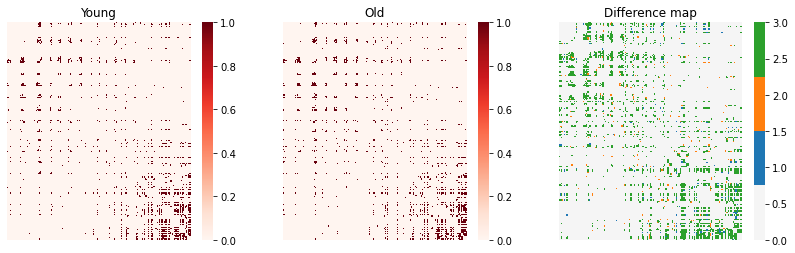

In [143]:
%matplotlib inline
diff.plot_binarized_maps(young, old, diff_map, filtering = False)

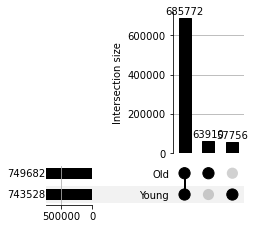

In [141]:
# How strongly do the interactions overlap
def get_interaction_list(df):
    numpy = df.to_numpy()
    rows, cols = np.where(numpy == 1)
    rows = df.index[rows]
    cols = df.columns[cols]
    interactions = [rows[ix] + "-" + cols[ix] for ix in range(0, len(rows))]
    return interactions

intersections = from_contents({'Young': get_interaction_list(young),
                               'Old': get_interaction_list(old)})
upset = UpSet(intersections, subset_size='count', show_counts = True,  
              sort_by="cardinality", min_subset_size = 1, sort_categories_by=None).plot()

# 2. Number of intermingling regions per chromosome pair

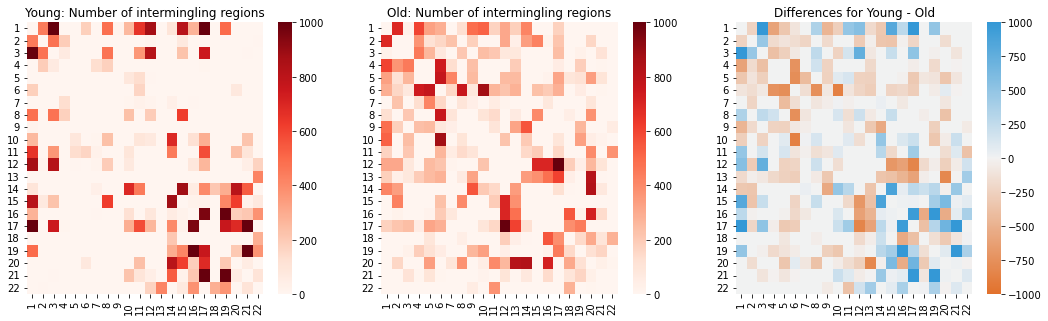

In [28]:
chr_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
fig, axs = plt.subplots(1, 3, figsize = (18, 5))
diff.plot_specific_intermingling(chr_list, diff_map, "Young", axs[0])
diff.plot_specific_intermingling(chr_list, diff_map, "Old", axs[1])
diff.plot_intermingling_diff(chr_list, diff_map, "Young", "Old", axs[2], -1000, 1000)
#plt.savefig(fig_dir + 'specific_intermingling_per_chr_pair.png')
plt.show()

# 3. Targets of selected TFs
## a) BACH2

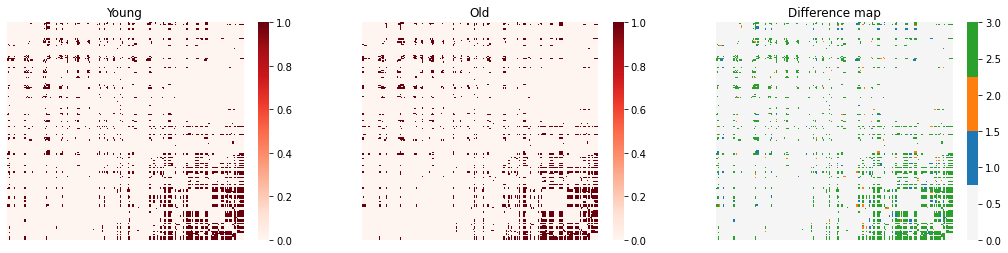

In [92]:
young_BACH2 = pd.read_csv(hic_dir+'Young_combi/binarized_maps/BACH2_subset.csv', index_col = 0)
old_BACH2 = pd.read_csv(hic_dir+'Old_combi/binarized_maps/BACH2_subset.csv', index_col = 0)
BACH2_loci = pd.read_csv(save_dir + 'TF_targets/BACH2_targets_loci.csv')

# Differences between young and old
diff_BACH2 = young_BACH2 + 2 * old_BACH2
#diff_BACH2 = diff_BACH2.loc[(diff_BACH2!=0).any(axis=1), (diff_BACH2!=0).any(axis=1)]

diff.plot_binarized_maps(young_BACH2, old_BACH2, diff_BACH2, filtering = False)

(325, 325)


<Figure size 432x288 with 0 Axes>

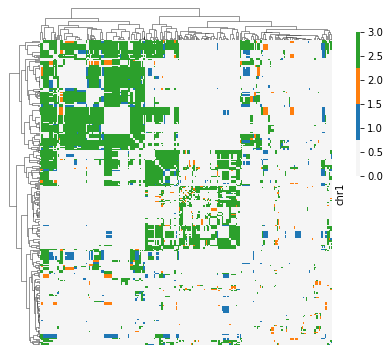

In [93]:
diff_BACH2_sub = diff_BACH2.loc[(diff_BACH2.isin([1,2])).any(axis=1), (diff_BACH2.isin([1,2])).any(axis=1)]
print(diff_BACH2_sub.shape)

diff.plot_clustered_diff_map(diff_BACH2_sub, 'BACH2', fig_dir)

In [101]:
# old intermingling loci that are active in old
selected_loci = diff_BACH2.loc[(diff_BACH2==2).any(axis=1), (diff_BACH2==2).any(axis=1)].columns
loci_activity = pd.read_csv(save_dir + "active_loci/loci_activity.csv")
active = loci_activity[loci_activity['old'] == 'active']
selected_loci = selected_loci[selected_loci.isin(active['locus'])]

selected_genes = BACH2_loci.loc[BACH2_loci['locus'].isin(selected_loci), 'gene']
 
# GSEA on old genes
enr = gseapy.enrichr(gene_list= selected_genes, 
                     gene_sets='GO_Biological_Process_2021', 
                     description='',  format='png',
                     verbose=False)
# Visualize results
#enr.results.head(5)
barplot(enr.res2d, title='Old',
        cutoff=0.05, top_term=5, figsize=(7, 3), color='salmon')

2022-10-10 07:21:01,282 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = 0.05


Above procedure takes all loci that have some cell-state specific intermingling. 
Below: assign each locus to cell state with maximum iintermingling

In [107]:
# get numbers of intermingling regions per cell state per locus
young = (diff_BACH2 == 1).sum(axis=1)
old = (diff_BACH2 == 2).sum(axis=1)
occurrences = pd.DataFrame({'young': young, 'old': old}, index = diff_BACH2.index)
occurrences = occurrences.loc[(occurrences!=0).any(axis=1), ]

percentages = occurrences.copy()
percentages['young'] = percentages['young'] / occurrences.sum(axis = 1)
percentages['old'] = percentages['old'] / occurrences.sum(axis = 1)
percentages = percentages.sort_values(by=['young', 'old'], ascending=False)
percentages.to_csv(hic_dir + 'difference_maps/percentages_specific_intermingling_BACH2.csv')
percentages.head()

,young,old
chr1,,
chr_1_loc_1750000,1.0,0.0
chr_1_loc_37750000,1.0,0.0
chr_1_loc_39000000,1.0,0.0
chr_1_loc_40250000,1.0,0.0
chr_1_loc_42750000,1.0,0.0


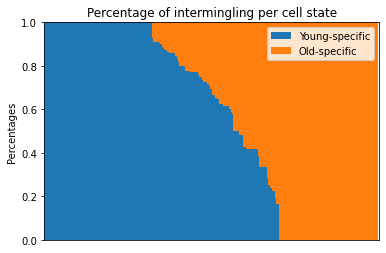

In [108]:
# plot percentages of occurrences as stacked bar plot
fig, ax = plt.subplots()
x_pos = [i for i in range(percentages.shape[0])]
ax.bar(x_pos, percentages['young'], label='Young-specific', width = 1)
ax.bar(x_pos, percentages['old'], bottom=percentages['young'], label='Old-specific', width = 1)

ax.set_ylabel('Percentages')
ax.set_title('Percentage of intermingling per cell state')
ax.legend()

ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
plt.xlim([0,percentages.shape[0]])

plt.show()

In [122]:
percentages['max'] = percentages.max(axis = 1)
loci_young = percentages[percentages['young'] == percentages['max']].index
loci_old = percentages[percentages['old'] == percentages['max']].index
print('Number of young-specific loci: ', len(loci_young))
print('Number of old-specific loci: ', len(loci_old))

Number of young-specific loci:  105
Number of old-specific loci:  97


In [125]:
# Gene ontology analysis
selected_loci = loci_old
all_loci = pd.read_csv(data_dir+'genome_data/all_gene_loci.csv')
selected_genes = all_loci.loc[all_loci['locus'].isin(selected_loci), 'gene']
# Filter for active genes
gene_activity = pd.read_csv(save_dir + "active_loci/gene_activity_hic.csv")
gene_activity = gene_activity[gene_activity['cell_state']=='old']
gene_activity = gene_activity[gene_activity['activity'] == "active"]
selected_genes = selected_genes[selected_genes.isin(gene_activity['gene_symbol'])]
 
# GSEA on old genes
enr = gseapy.enrichr(gene_list= selected_genes, 
                     gene_sets='GO_Biological_Process_2021', 
                     description='',  format='png',
                     verbose=False)
# Visualize results
#enr.results.head(5)
barplot(enr.res2d, title='Young',
        cutoff=0.05, top_term=5, figsize=(7, 3), color='salmon')

2022-10-11 05:02:14,213 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = 0.05


In [126]:
enr.results.head(5)

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene_set
0,regulation of cell cycle (GO:0051726),10/296,0.000276,0.155959,0,0,4.165956,34.133760,RB1;CSNK2A1;DUSP1;CDC26;RPS6KA2;CHEK1;PLK1;HNR...,GO_Biological_Process_2021
1,histone deubiquitination (GO:0016578),3/19,0.000566,0.155959,0,0,21.721491,162.408887,USP7;USP16;UIMC1,GO_Biological_Process_2021
2,negative regulation of cell cycle (GO:0045786),5/80,0.000668,0.155959,0,0,7.791321,56.964303,RB1;DUSP1;RPS6KA2;PLK1;HECA,GO_Biological_Process_2021
3,anaphase-promoting complex-dependent catabolic...,5/84,0.000834,0.155959,0,0,7.395326,52.425594,RB1;PSMD5;CDC26;PLK1;PSMD1,GO_Biological_Process_2021
4,regulation of mitotic cell cycle (GO:0007346),7/178,0.000959,0.155959,0,0,4.817908,33.483879,RB1;PSMD5;CDC26;PLK1;HNRNPU;PSMD1;HECA,GO_Biological_Process_2021


## b) HIF1A

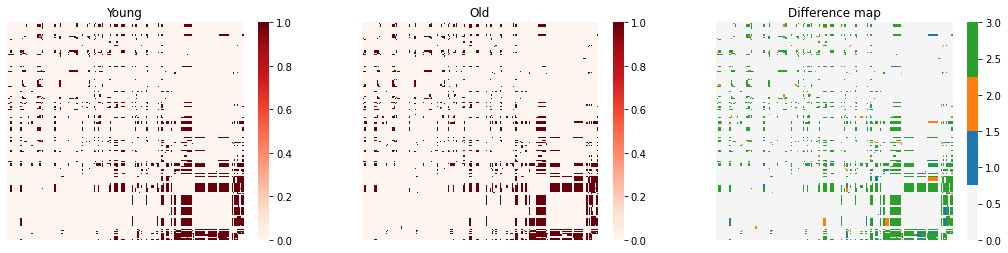

In [104]:
young_HIF1A = pd.read_csv(hic_dir+'Young_combi/binarized_maps/HIF1A_subset.csv', index_col = 0)
old_HIF1A = pd.read_csv(hic_dir+'Old_combi/binarized_maps/HIF1A_subset.csv', index_col = 0)
HIF1A_loci = pd.read_csv(data_dir + 'TF_targets/HIF1A_targets_loci.csv')

# Differences between young and old
diff_HIF1A = young_HIF1A + 2 * old_HIF1A
#diff_HIF1A = diff_HIF1A.loc[(diff_HIF1A!=0).any(axis=1), (diff_HIF1A!=0).any(axis=1)]

diff.plot_binarized_maps(young_HIF1A, old_HIF1A, diff_HIF1A, filtering = False)

<Figure size 432x288 with 0 Axes>

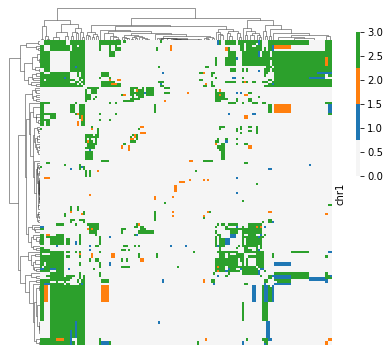

In [97]:
diff.plot_clustered_diff_map(diff_HIF1A, 'HIF1A', fig_dir)

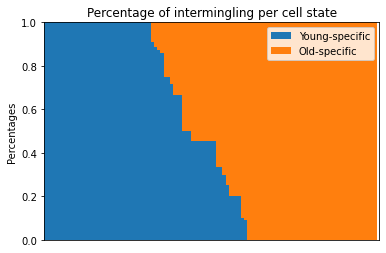

In [128]:
# get numbers of intermingling regions per cell state per locus
young = (diff_HIF1A == 1).sum(axis=1)
old = (diff_HIF1A == 2).sum(axis=1)
occurrences = pd.DataFrame({'young': young, 'old': old}, index = diff_HIF1A.index)
occurrences = occurrences.loc[(occurrences!=0).any(axis=1), ]

percentages = occurrences.copy()
percentages['young'] = percentages['young'] / occurrences.sum(axis = 1)
percentages['old'] = percentages['old'] / occurrences.sum(axis = 1)
percentages = percentages.sort_values(by=['young', 'old'], ascending=False)
percentages.to_csv(hic_dir + 'difference_maps/percentages_specific_intermingling_HIF1A.csv')

# plot percentages of occurrences as stacked bar plot
fig, ax = plt.subplots()
x_pos = [i for i in range(percentages.shape[0])]
ax.bar(x_pos, percentages['young'], label='Young-specific', width = 1)
ax.bar(x_pos, percentages['old'], bottom=percentages['young'], label='Old-specific', width = 1)

ax.set_ylabel('Percentages')
ax.set_title('Percentage of intermingling per cell state')
ax.legend()

ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
plt.xlim([0,percentages.shape[0]])

plt.show()

In [132]:
percentages['max'] = percentages.max(axis = 1)
loci_young = percentages[percentages['young'] == percentages['max']].index
loci_old = percentages[percentages['old'] == percentages['max']].index
print('Number of young-specific loci: ', len(loci_young))
print('Number of old-specific loci: ', len(loci_old))

Number of young-specific loci:  48
Number of old-specific loci:  63


In [134]:
# Gene ontology analysis
selected_loci = loci_old
all_loci = pd.read_csv(data_dir+'genome_data/all_gene_loci.csv')
selected_genes = all_loci.loc[all_loci['locus'].isin(selected_loci), 'gene']
# Filter for active genes
gene_activity = pd.read_csv(save_dir + "active_loci/gene_activity_hic.csv")
gene_activity = gene_activity[gene_activity['cell_state']=='old']
gene_activity = gene_activity[gene_activity['activity'] == "active"]
selected_genes = selected_genes[selected_genes.isin(gene_activity['gene_symbol'])]
 
# GSEA on old genes
enr = gseapy.enrichr(gene_list= selected_genes, 
                     gene_sets='GO_Biological_Process_2021', 
                     description='',  format='png',
                     verbose=False)
# Visualize results
#enr.results.head(5)
barplot(enr.res2d, title='Old',
        cutoff=0.05, top_term=5, figsize=(7, 3), color='salmon')

2022-10-11 05:07:17,930 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = 0.05
